### Chapter 7

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Lorenz-63 model
Taken from Chapter 1, Example 8. Lorenz model as a surrogate physical process

In [3]:
sigm = 10.
rho = 28.
beta = 8./3
dt = 0.001
Nout = 50
a = 1. / np.sqrt(dt)
fakt = 1.99999
N = 2 * 10**5

# initial conditions
x = -.587
y = -.563
z = 16.870
g1 = a * (1. / np.sqrt(2.) - .5)
g2 = a * (1. / np.sqrt(3.) - .5)
g3 = a * (1. / np.sqrt(5.) - .5)
res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
        
for i in range(N):
    res[i,:] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
    
    xn = x + dt * (sigm * (y - x)) + dt * g1
    yn = y + dt * (x * (rho - z) - y) + dt * g2
    zn = z + dt * (x * y - beta * z) + dt * g3
    
    x, y, z = xn, yn, zn
    
res[:,0] *= dt

# store only points with dt = 0.05
ressug = res[::Nout]

# add measurement error using tent map
meas = np.zeros((N*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2.**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

# observation of x-component (dt = 0.05, first 200 datapoints)
obsx = np.zeros((N/Nout,3))
j = 0
i = 0

for k in range(0,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
obs = [obsx[:,0], obsx[:,1] + obsx[:,2]]
obs = np.array(obs)

### Example 7.9 (Ensemble Kalman Filter with perturbed observations (EnKF))
The analysis step (Algorithm 7.7. (ii)) consists of
1. $rpert = Hz^f_i + \xi_j - y_{obs}$. The forward operator $H$ is $x_{\text{ref}}$. So `reprt = x - xobs + sqrt(R) * randn(M)`.
2. $P_m^f = \frac{1}{M-1} \sum_i^{M} (z^f_i - \bar{z}^f_i)(z^f_i - \bar{z}^f_i)^T$. Let $dX = X - \bar{X}$, where $X := z^f \in \mathbb{R}^{3 \times M}$. Then `dX = X - np.mean(X,axis=1)`. The outer product is given by $dX \times dX^T \in \mathbb{R}^{3 \times M \times 3}$, $dX \in \mathbb{R}^{3 \times M \times 1}, dX^T \in \mathbb{R}^{1 \times M \times 3}$. So `P = 1/(M-1) * (dX * dX.T).sum(axis=1)`.
3. $K = P_m^f H^T (H P_M^f H^T + R)^{-1}$. $P_m^f H^T =$ first column of $P_m^f$, while $H P_M^f H^T$ is the first-most entry of $P_m^f$, i.e. `P[0,0]`. So `K = P[:,0] / (P[0,0] + R)`
4. $z^a = z^f - K \cdot rpert^T$. `z^a = z^f - outer(K,reprt)`.

Tidy up the above whenever possible.

In [ ]:
STEPS = 5*40
R = 1./15

# recall that from example 4.8, the Lorenz model with drift term f(x) set to zero can be modelled 
# by a stochastic difference equation with mean = 0, var = 0.0838.
var = 0.0838

# sigma value given in example 6.9.
sigma = 0.1

NN = 19
m = np.arange(1,NN+1)
m = 2*m+2
#m = np.array([4])

rmse_x = np.zeros((NN))
rmse_y = np.zeros((NN))
rmse_z = np.zeros((NN))

for lkl in range(NN):
    M = m[lkl]
    
    x0 = -0.587
    y0 = -0.563
    z0 = 16.87
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t= np.zeros((STEPS+1))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.mean(x)
    y_f[0] = np.mean(y)
    z_f[0] = np.mean(z)
    
    rmse_x[lkl] = 0.
    rmse_y[lkl] = 0.
    rmse_z[lkl] = 0.
    
    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh
            
            # step within each observation window by means of the stochastic Lorenz-63 model
            xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)

        # Calculate residual: (forward map of reference - yobs)
        r = xh - obs[1,j+1]
        # Hz^f_i + eta_i - y_{obs} = rpert
        rpert = r + np.sqrt(R) * np.random.randn(M)
        
        x = xh
        y = yh
        z = zh
        
        X = np.vstack((x,y,z))
        dX = X - np.mean(X, axis=1).reshape(-1,1)

        P = dX[:,:,None] * dX.T[None,:,:]
        P = P.sum(axis=1)/(M-1)
        
        K = P[:,0] / (P[0,0] + R)
        X -= np.outer(K,rpert)

        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
        
        x_f[j+1] = np.mean(x)
        y_f[j+1] = np.mean(y)
        z_f[j+1] = np.mean(z)
        t[j+1] = dt * Nout * (j+1)
        
        rmse_x[lkl] = rmse_x[lkl] + (x_f[j+1] - ressug[j+1,1])**2
        rmse_y[lkl] = rmse_y[lkl] + (y_f[j+1] - ressug[j+1,2])**2
        rmse_z[lkl] = rmse_z[lkl] + (z_f[j+1] - ressug[j+1,3])**2
        
    rmse_x[lkl] = np.sqrt(rmse_x[lkl] / STEPS)
    rmse_y[lkl] = np.sqrt(rmse_y[lkl] / STEPS)
    rmse_z[lkl] = np.sqrt(rmse_z[lkl] / STEPS)

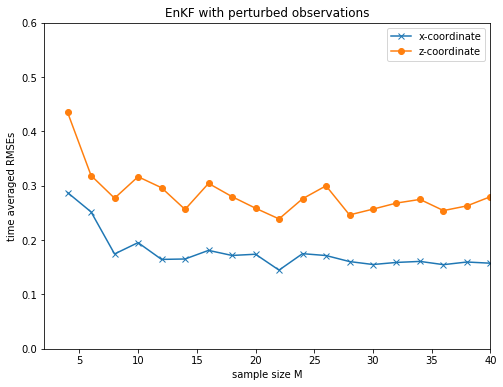

In [101]:
fig0a = plt.figure(figsize=(8,6))
plt.plot(m,rmse_x, 'x-', label="x-coordinate")
plt.plot(m,rmse_z, 'o-', label="z-coordinate")
plt.xlim([2,40])
plt.ylim([0,0.6])
plt.xlabel("sample size M")
plt.ylabel("time averaged RMSEs")
plt.title("EnKF with perturbed observations")
plt.legend()
plt.show()

### Example 7.9 (Ensemble Square Root Filter (ESRF))
From Algorithm 7.8 (ii):
1. First get the Kalman gain matrix $K$. This is equivalent to steps 2. and 3. from above.
2. Get the analysis mean given by eqn 7.8, $\bar{z}^a = \bar{z}^f_M - K(H\bar{z}_M^f - y_{obs})$.
3. Derive the matrix $S$ using eqn 7.22. Here, $HA^f$ is the x-component of the $dX$ matrix from above.
4. Then derive $z^a_i$ using eqn 7.26, i.e. $z^a_i = \bar{z}^a + dX \cdot S$.

In [145]:
from scipy.linalg import sqrtm

STEPS = 5*40
R = 1./15

# recall that from example 4.8, the Lorenz model with drift term f(x) set to zero can be modelled 
# by a stochastic difference equation with mean = 0, var = 0.0838.
var = 0.0838

# sigma value given in example 6.9.
sigma = 0.1

NN = 20
m = np.arange(1,NN+1)
m = 2*m

rmse_x = np.zeros((NN))
rmse_y = np.zeros((NN))
rmse_z = np.zeros((NN))

for lkl in range(NN):
    M = m[lkl]
    
    x0 = -0.587
    y0 = -0.563
    z0 = 16.87
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t= np.zeros((STEPS+1))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.mean(x)
    y_f[0] = np.mean(y)
    z_f[0] = np.mean(z)
    
    rmse_x[lkl] = 0.
    rmse_y[lkl] = 0.
    rmse_z[lkl] = 0.
    
    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh
            
            # step within each observation window by means of the stochastic Lorenz-63 model
            xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)
        
        x = xh
        y = yh
        z = zh
        
        # Get the Kalman gain matrix K.
        X = np.vstack((x,y,z))
        dX = X - np.mean(X, axis=1).reshape(-1,1)

        P = dX[:,:,None] * dX.T[None,:,:]
        P = P.sum(axis=1)/(M-1)
        
        K = P[:,0] / (P[0,0] + R)
        
        # mean of analysis, eqn 7.8
        xmean = np.mean(X,axis=1)
        xmean = xmean - K*(xmean[0] - obs[1,j+1])
        
        # Get the S matrix, eqn 7.22
        Y = dX[0,:] / np.sqrt(M-1)
        Y = Y.reshape(-1,1) # to make transpose sensible - 1D arrays not transposable!
        S2 = np.linalg.inv(sqrtm(np.eye(M) + Y.T * Y / R)).real
        dX = np.dot(dX,S2)
        
        X = xmean.reshape(-1,1) * np.ones(1,M) + dX

        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
        
        x_f[j+1] = np.mean(x)
        y_f[j+1] = np.mean(y)
        z_f[j+1] = np.mean(z)
        t[j+1] = dt * Nout * (j+1)
        
        rmse_x[lkl] = rmse_x[lkl] + (x_f[j+1] - ressug[j+1,1])**2
        rmse_y[lkl] = rmse_y[lkl] + (y_f[j+1] - ressug[j+1,2])**2
        rmse_z[lkl] = rmse_z[lkl] + (z_f[j+1] - ressug[j+1,3])**2
        
    rmse_x[lkl] = np.sqrt(rmse_x[lkl] / STEPS)
    rmse_y[lkl] = np.sqrt(rmse_y[lkl] / STEPS)
    rmse_z[lkl] = np.sqrt(rmse_z[lkl] / STEPS)

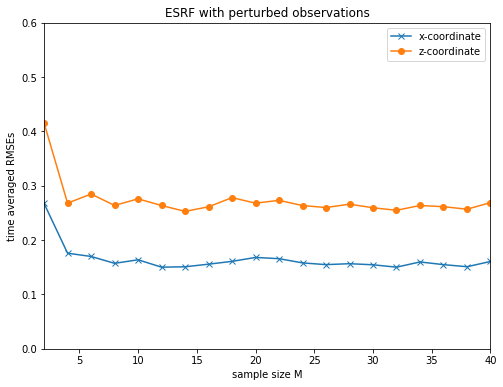

In [146]:
fig0a = plt.figure(figsize=(8,6))
plt.plot(m,rmse_x, 'x-', label="x-coordinate")
plt.plot(m,rmse_z, 'o-', label="z-coordinate")
plt.xlim([2,40])
plt.ylim([0,0.6])
plt.xlabel("sample size M")
plt.ylabel("time averaged RMSEs")
plt.title("ESRF with perturbed observations")
plt.legend()
plt.show()